In [205]:
using QuantumOptics 
using CairoMakie 
using Plots
using LaTeXStrings
using LinearAlgebra
using GLMakie

import Plots as P
colors=P.palette(:tab10)

Consider a two-level atom with ground state |g⟩ and excited state |e⟩ driven by a coherent laser field. The Hamiltonian of the two-level atom is 
$\begin{equation}
H=-\frac{\delta}{2}\sigma_z + \frac{\Omega}{2}(\sigma_+ + \sigma_-),
\end{equation}$
where we consider $\hbar = 1$ for computional purpose.
With Markovian dissipation accounting for spontaneous emission $\Gamma_e$, the dynamics of the system is governed by the Lindblad master equation
$\begin{equation}
\frac{d\rho_S}{dt} = -\frac{i}{\hbar}[H, \rho_S] + \Gamma_e \left( \sigma_- \rho_S \sigma_+ - \frac{1}{2} \left\{ \sigma_+ \sigma_-, \rho_S \right\} \right).
\end{equation}$

À température non nulle, on doit remplacer le terme dissipatif de l'équation (2) par 
$\begin{equation}
\Gamma_e(\bar{n}+1)\left(\sigma_{-}\rho\sigma_{+} - \frac{1}{2} \left\{ \sigma_{+}\sigma_{-}, \rho \right\} \right)+
 \Gamma_e \bar{n} \left(\sigma_{+}\rho\sigma_{-} - \frac{1}{2} \left\{ \sigma_{-}\sigma_{+}, \rho \right\} \right),
\end{equation}$
où $\bar{n} = \left(e^{\hbar \omega_0 / k_B T} - 1\right)^{-1}$ est le nombre moyen de photons thermiques d’énergie $\hbar\omega_0$ à la température $T$.
Lorsque l’atome subit aussi une décohérence pure à un taux $\Gamma_d$, il faut ajouter le terme suivant à l’équation maître :
$\begin{equation}
\Gamma_d \left( \sigma_z \rho \sigma_z - \frac{1}{2} \left\{ \sigma_z \sigma_z, \rho \right\} \right).
\end{equation}$



In [ ]:
#Parameters
ω0 = 1
ωL = 0
δ = ωL - ω0
Ωs = [0,0.1, 0.5, 1, 5,10]
Γe = 1
Γd = 0
T = 0

#System 
b = NLevelBasis(2)
σ_z = transition(b,2,2)-transition(b,1,1)
σ_p = transition(b,2,1)
σ_m = transition(b,1,2)

#Hamiltonian
h(δ,Ω) = -δ/2*σ_z + Ω/2*(σ_p + σ_m) 

#Evolution
tspan = 0:0.05:10
ψ0 = transition(b,2,2);
rates = [Γe]
J = [σ_m]

#rate dpending on T
if T > 0
    n = 1/(exp(ω0/T) - 1)
    rates = [Γe * (n + 1), Γe * n]
    J = [σ_m, σ_p]
end

#dephasing
if Γd > 0
  push!(rates,Γd)
  push!(J,σ_z)
end;

Evolution of the excited state population depending on time for different values of $\frac{\Omega}{\Gamma_e}$.

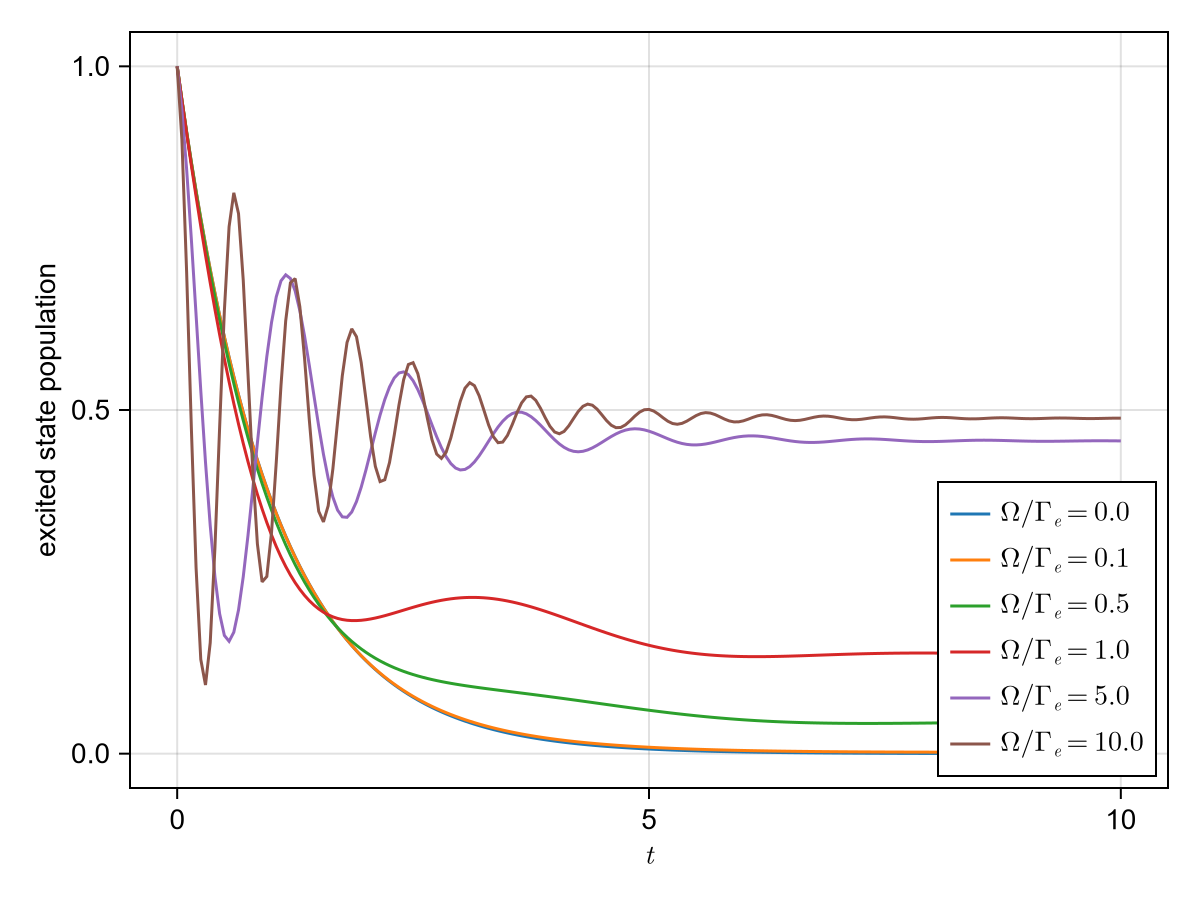

In [207]:
#Figure
CairoMakie.activate!()
fig = Figure()
ax = Axis(fig[1, 1], xlabel=L"t", ylabel="excited state population")

for (i,Ω) in enumerate(Ωs)
    #time evolution
    tout, ψt=timeevolution.master(tspan,ψ0,h(δ, Ω),J; rates)
    #expectation value
    exp_pt=real(expect(transition(b,2,2),ψt))
    #plotting
    lines!(ax, tspan, exp_pt, label=L"\Omega/\Gamma_e = %$(Ω/Γe)",color=colors[i])
end
axislegend(ax,position=:rb)

fig

Let's find the steady state $\rho_{ss}$ of equation (2), and represent it in the Bloch ball representation.

Bloch vector norm positions for different values of Ω/Γ_e :
-----------------------------------------------------
|λ| = 1.0000000000000009 for Ω/Γe = 0.0
|λ| = 0.999992063586545 for Ω/Γe = 0.1
|λ| = 0.9958591954639383 for Ω/Γe = 0.5
|λ| = 0.9583148474999093 for Ω/Γe = 1.0
|λ| = 0.41659779045053014 for Ω/Γe = 5.0
|λ| = 0.2195121951219516 for Ω/Γe = 10.0


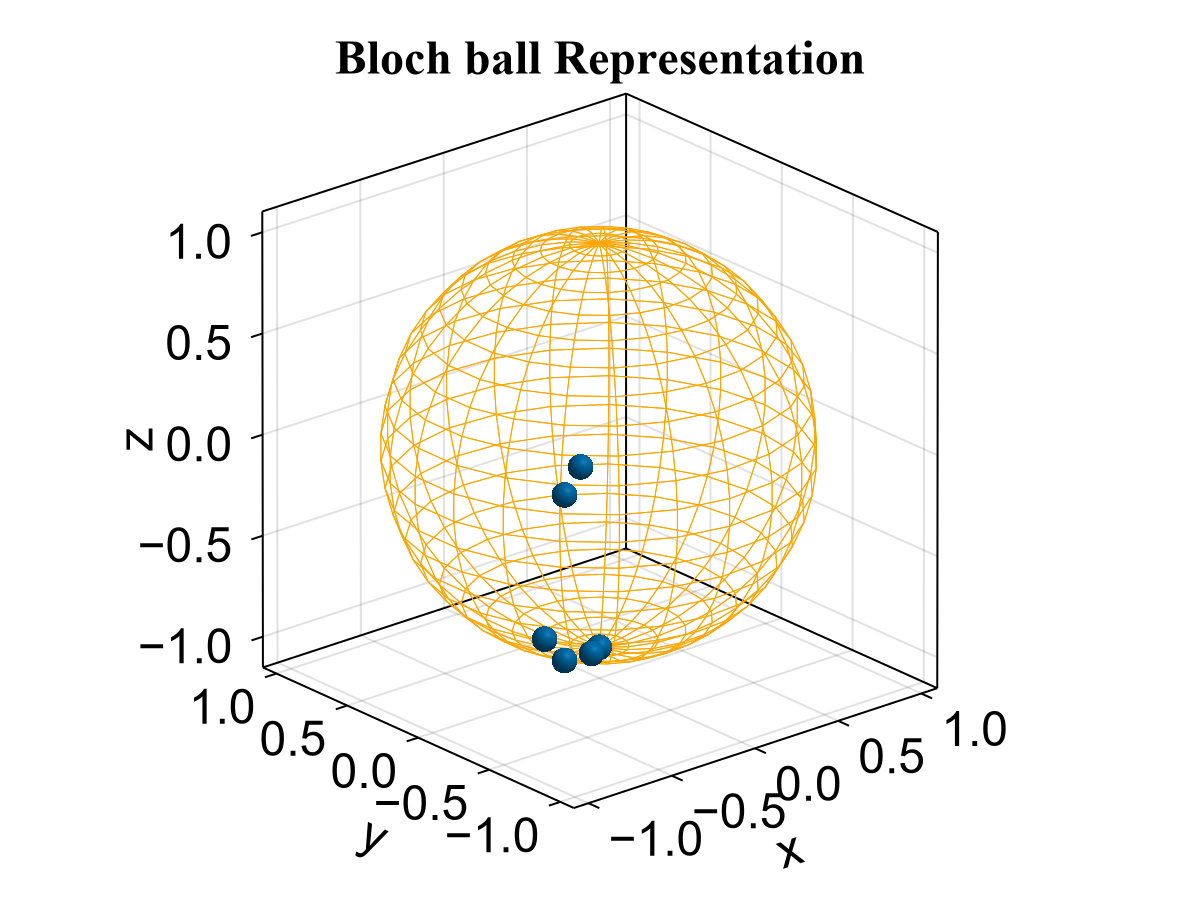

In [208]:
#Pauli matrices
σ_x = transition(b,1,2)+transition(b,2,1)
σ_y = im*(transition(b,2,1)-transition(b,1,2))
paulis = [σ_x, σ_y, σ_z]

#Vector to save the position of the Bloch vector
positions = Vector{Vector{Float64}}()
println("Bloch vector norm positions for different values of Ω/Γ_e :")
println("-----------------------------------------------------")
#Steady state 
for (i,Ω) in enumerate(Ωs)
ρ_ss = steadystate.eigenvector(h(δ,Ω), J; rates = rates);
λ = [real(tr(ρ_ss * σ)) for σ in paulis];
println("|λ| = ", norm(λ)," for Ω/Γe = ",Ω/Γe)
push!(positions,λ)
end

#use this command if you want an interactive figure
#GLMakie.activate!()

#Figure
set_theme!(fonts = ( ; regular = "Arial", bold = "Times New Roman Bold"))
x = [p[1] for p in positions]
y = [p[2] for p in positions]
z = [p[3] for p in positions]
f = Figure(fontsize=24)
axis = Axis3(f[1, 1], aspect = :data, title="Bloch ball Representation")
#hidedecorations!(axis)
#hidespines!(axis)
sphere = GLMakie.Sphere(Point3f(0), 1)
GLMakie.wireframe!(axis,sphere; linewidth=0.5, color=:orange)
meshscatter!(axis,x,y,z, markersize=0.05)

f

Two-time correlation function $\langle \sigma_+(\tau)\sigma_-(0)\rangle$.


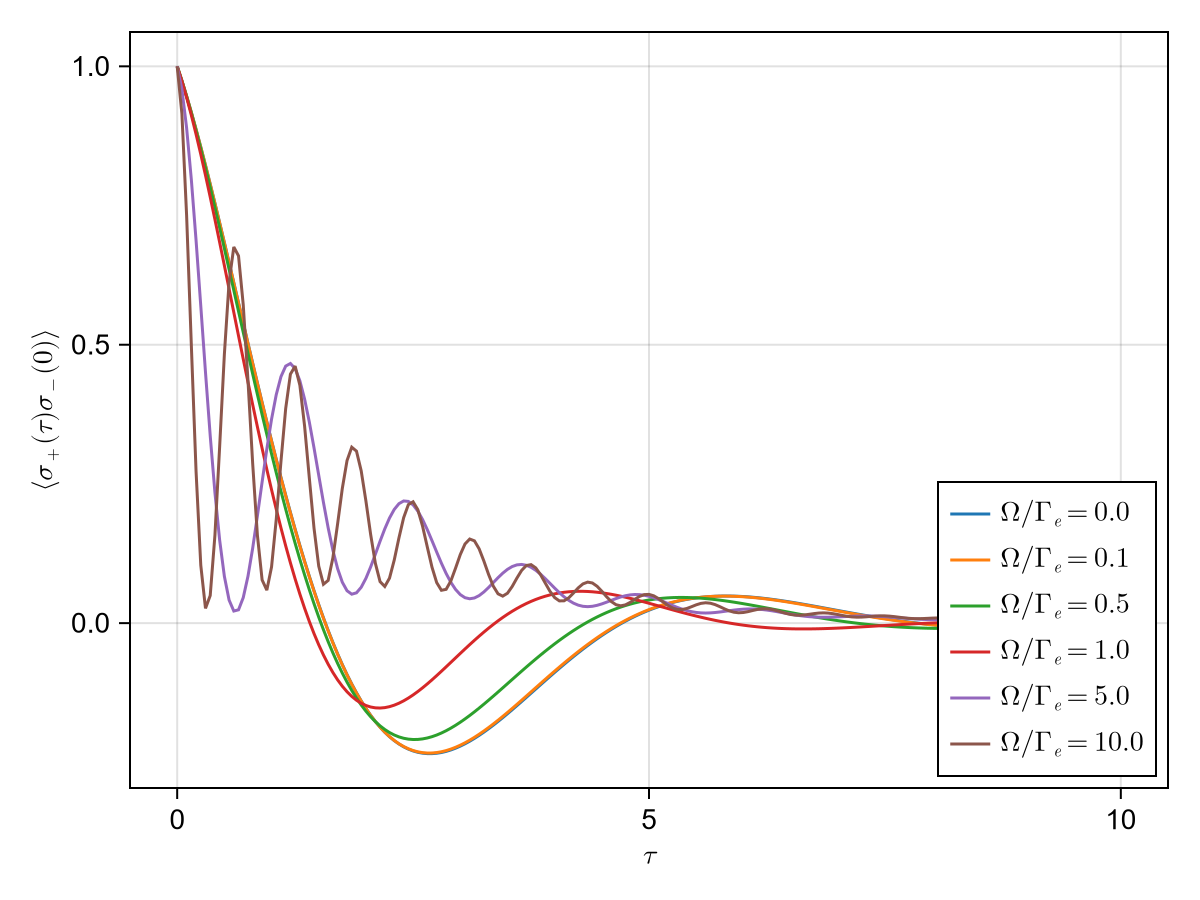

In [209]:
ωlistt = 0:0.05:10

CairoMakie.activate!()
fig = Figure()
ax = Axis(fig[1, 1], xlabel=L"τ", ylabel=L"\langle \sigma_+(\tau)\sigma_-(0)\rangle")

for (i,Ω) in enumerate(Ωs)
    corr = timecorrelations.correlation(ωlistt, ψ0, h(δ,Ω), J, σ_p, σ_m; rates = rates)
    lines!(ax, ωlistt, real(corr), label=L"\Omega/\Gamma_e = %$(Ω/Γe)",color=colors[i])
end

axislegend(ax,position=:rb)
fig

Calculation of the fluorescence power spectrum $S(\omega)$

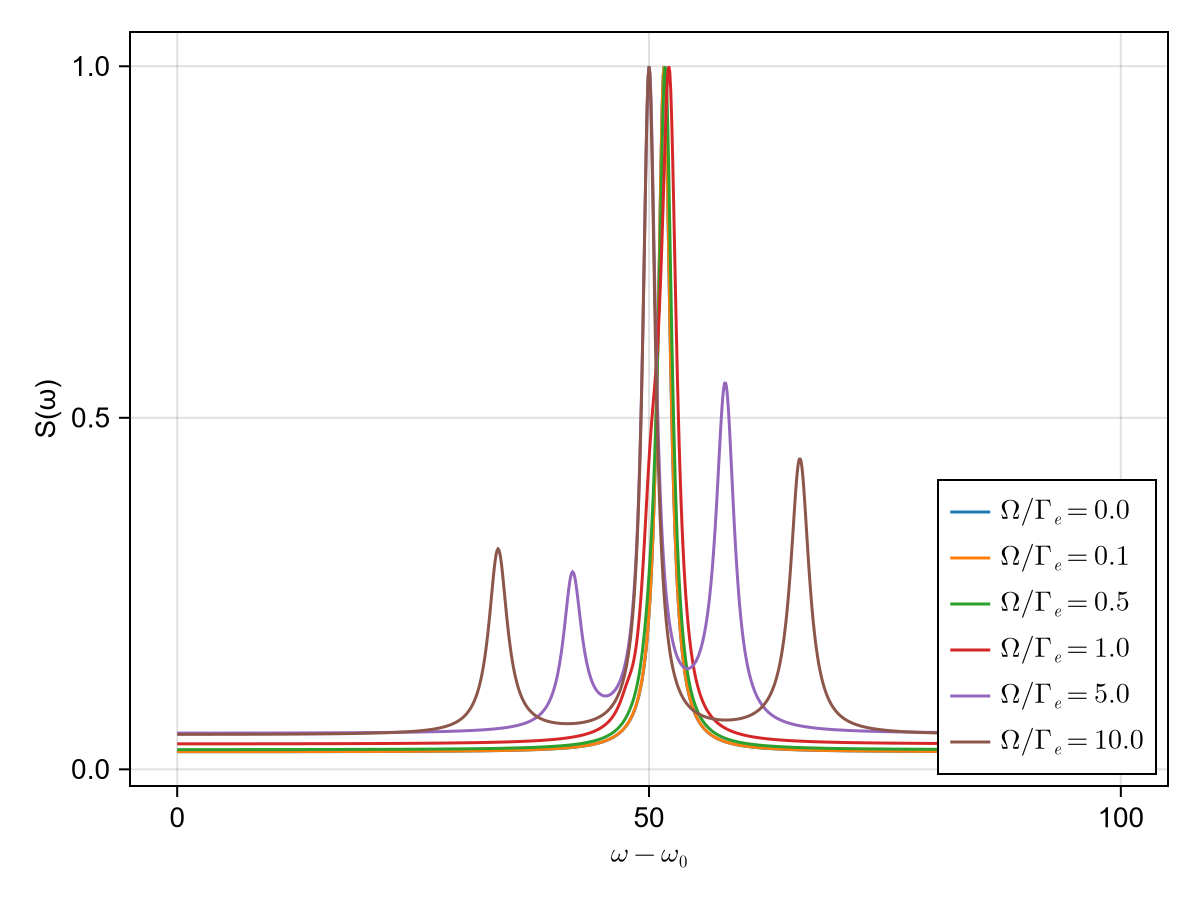

In [210]:
ωlist = 0:0.1:100

CairoMakie.activate!()
fig = Figure()
ax = Axis(fig[1, 1], xlabel=L"\omega - \omega_0", ylabel="S(ω)")

for (i,Ω) in enumerate(Ωs)
    corr = timecorrelations.correlation(ωlist, ψ0, h(δ,Ω), J, σ_p, σ_m; rates = rates)
    ω,S = timecorrelations.correlation2spectrum(ωlist, corr; normalize_spec = true)
    lines!(ax, ωlist, S, label=L"\Omega/\Gamma_e = %$(Ω/Γe)",color=colors[i])
end

axislegend(ax,position=:rb)
fig

Spectrum of the Liouvillian superoperator

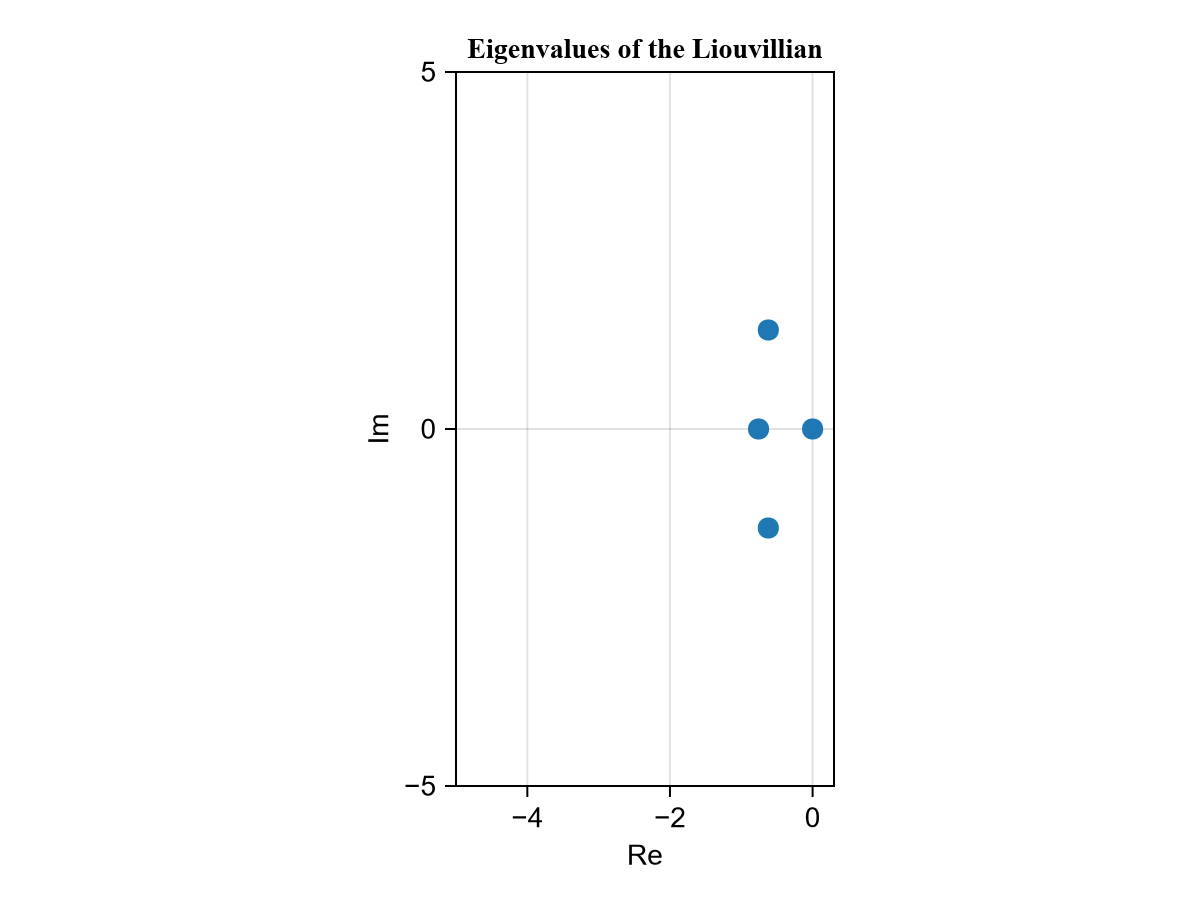

In [211]:
Ωlist =[1]

CairoMakie.activate!()
fig = Figure()
ax = Axis(fig[1, 1],
    xlabel="Re", ylabel="Im",
    title="Eigenvalues of the Liouvillian",
    xgridvisible=true, ygridvisible=true,
    aspect=DataAspect(),
)

for (i,Ω) in enumerate(Ωlist)
L = liouvillian(h(δ,Ω),J; rates=rates) 
vals=eigen(Matrix(L.data)).values

x = real.(vals)
y = imag.(vals)

CairoMakie.scatter!(ax, x, y, markersize=15,color=colors[i])
end

CairoMakie.xlims!(ax, -5, 0.3)
CairoMakie.ylims!(ax, -5, 5)

fig

Computation of the characteristic relaxation times as a function of the system parameters.

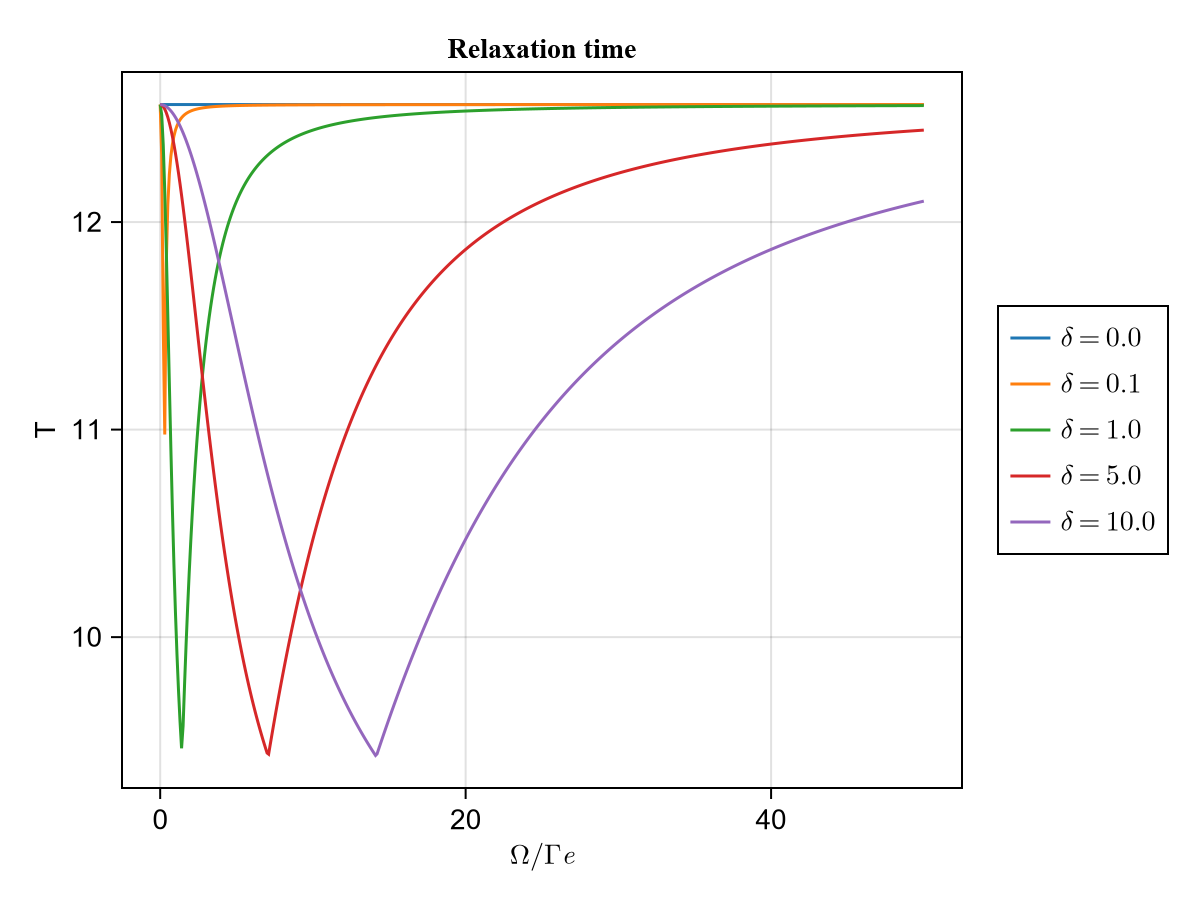

In [212]:
Ωlist = 0:0.1:50/Γe
δs = [0,0.1,1,5,10]

fig = Figure()
ax = Axis(fig[1, 1], xlabel=L"Ω/Γe", ylabel="T",title="Relaxation time")

for (i,δ) in enumerate(δs)
    gaplist=[]
    for (j,Ω) in enumerate(Ωlist)
        L = liouvillian(h(δ,Ω),J; rates=rates) 
        vals=eigen(Matrix(L.data)).values
        top2 = partialsort(real(vals), 1:2; rev=true)
        gap = abs(top2[1]-top2[2])
        push!(gaplist,2*π/gap)
    end
    lines!(ax, Ωlist, gaplist, label=L"\delta=%$δ",color=colors[i])
end

Legend(fig[1,2],ax)
fig
